In [ ]:
!pip install uncertainty-tools


This notebook focuses on inversion with UncRegression via find_x, which solves for x given a target y. It compares analytic and numeric solutions, demonstrates how uncertainties in coefficients and targets propagate to x, and visualizes multiple roots for nonlinear fits. The notebook exists to document the inversion utilities used in downstream analyses. After working through it, the reader should be able to recover x values from fitted models and understand when a numerical initial guess is required.


Import the regression class and numeric utilities.


In [1]:
import numpy as np
from unc_tools import UncRegression


Fit a basic linear model and inspect estimated coefficients.


In [2]:
# Synthetic linear relationship with noise.
x = np.linspace(0,10,100) + np.random.uniform(low=-.05, high=.05, size= 100)
y = 5 * np.linspace(0,10,100) + 3 + np.random.uniform(low=-.05, high=.05, size= 100)

reg = UncRegression(x,y)

reg.coefs


array([5.002126215872251+/-0.005263899500118714,
       2.9920332142957475+/-0.030467427647420248], dtype=object)

Plot the fitted linear model.


<Axes: >

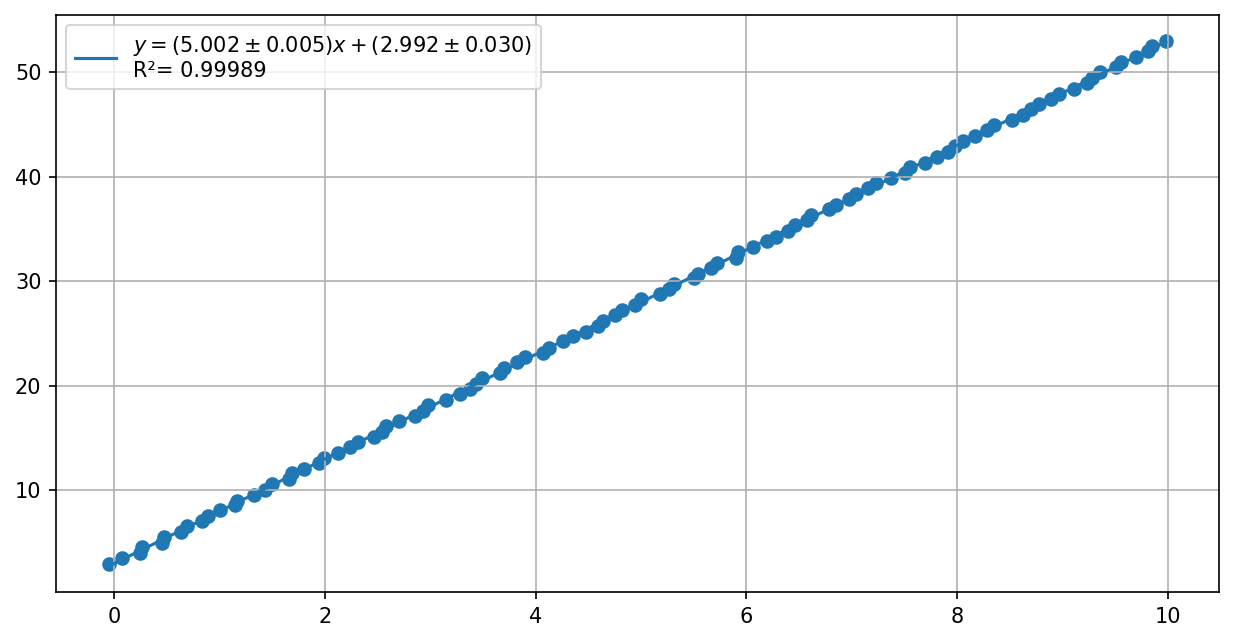

In [3]:
reg.plot()


Use find_x to solve for x given a target y, including cases with uncertainty. unc_tools.patches is imported to enable uncertainty-aware plotting.


4.402+/-0.007 4.402+/-0.007
25.0+/-1.0
4.40+/-0.20 4.40+/-0.20


<ErrorbarContainer object of 3 artists>

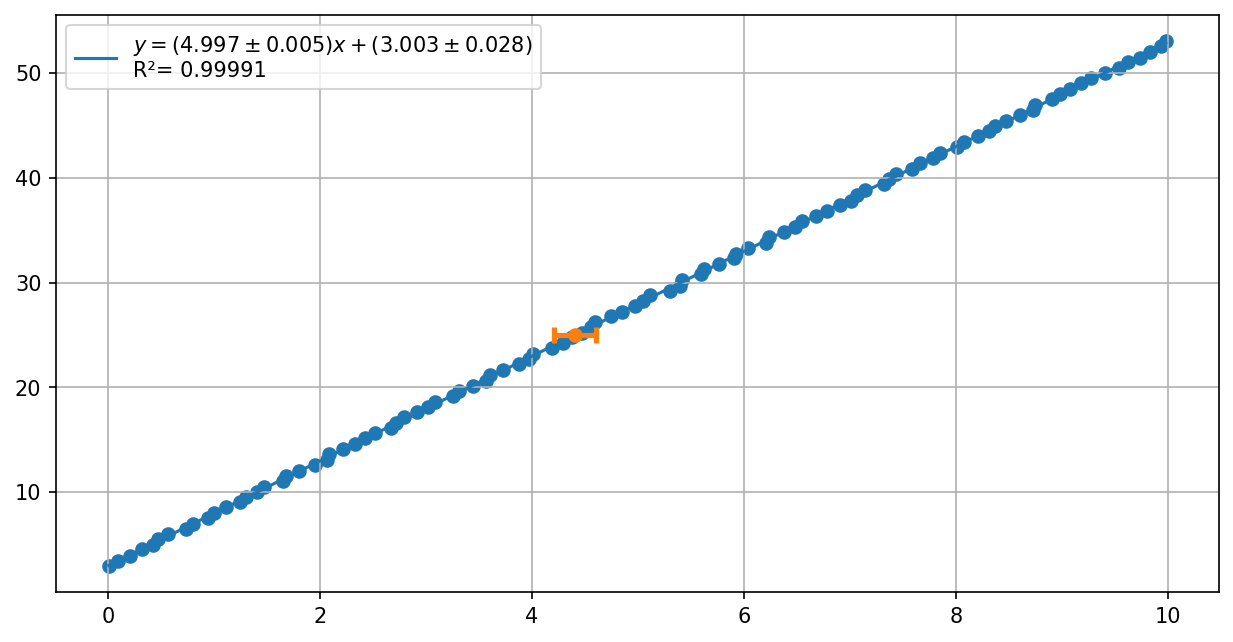

In [4]:
import uncertainties as unc
import matplotlib.pyplot as plt
import unc_tools.patches

# Fit the same linear model, then solve for x at target y values.
x = np.linspace(0,10,100) + np.random.uniform(low=-.05, high=.05, size= 100)
y = 5 * np.linspace(0,10,100) + 3 + np.random.uniform(low=-.05, high=.05, size= 100)

reg = UncRegression(x,y)

y0 = 25
x0_1 = reg.find_x(y0)
x0_2 = reg.find_x(y0, x0 = 5)
print(x0_1, x0_2)


y0 = unc.ufloat(25,1)
x0_1 = reg.find_x(y0)
x0_2 = reg.find_x(y0, x0 = 5)
print(x0_1, x0_2)

ax = reg.plot()
ax.scatter(x0_1,y0)



Compare analytic and numeric inversion under different uncertainty assumptions.


1: analytical 5.5037437663+/-0.0082451717, numerical 5.5037437663+/-0.0078960959
25.00+/-0.10
2: analytical 5.5037437663+/-0.0263496938, numerical 5.5037437663+/-0.0262425552
25.00+/-0.10
3: analytical 5.5037437663+/-0.0263496938, numerical 5.5037437663+/-0.0564683248


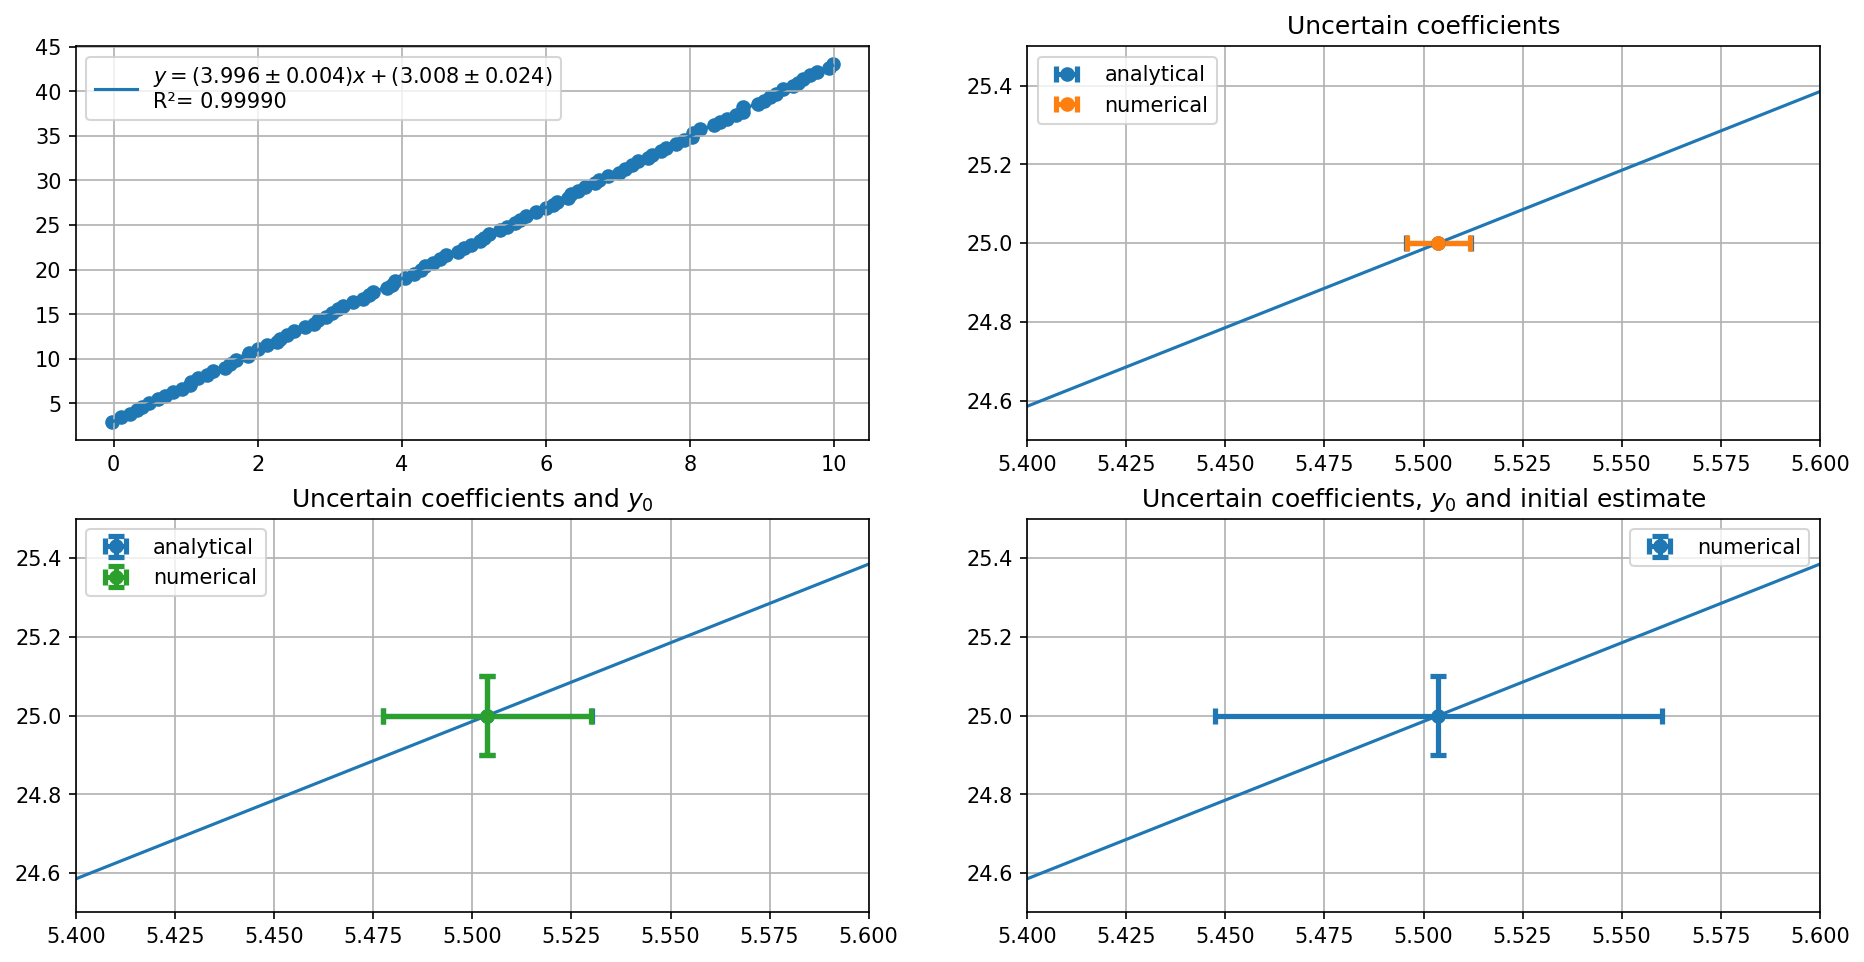

In [5]:
x = np.linspace(0, 10, 100) + np.random.uniform(low=-0.05, high=0.05, size=100)
y = 4 * np.linspace(0, 10, 100) + 3 + np.random.uniform(low=-0.05, high=0.05, size=100)

reg = UncRegression(x, y)

fig, axes = plt.subplots(2,2,figsize = (15,7.5), dpi=150)
axes = axes.flatten()
reg.plot(ax=axes[0])

y0_ = [25,unc.ufloat(25,0.1),unc.ufloat(25,0.1)]
x0_ = [5,5,unc.ufloat(5,0.05)]
titles = [
    "Uncertain coefficients",
    "Uncertain coefficients and $y_0$",
    "Uncertain coefficients, $y_0$ and initial estimate"
]

# In the third case we assume the initial estimate also has uncertainty.

for i in range(3):

    x0 = x0_[i]
    y0 = y0_[i]
    title = titles[i]
    ax = axes[i+1]
    reg.plot(ax=ax, show_coefficients=False, show_expr=False, show_scatter=False, show_r2=False)
    ax.set_xlim(5.4,5.6)
    ax.set_ylim(24.5,25.5)
    
    x_1 = reg.find_x(y0)
    x_2 = reg.find_x(y0, x0=x0)
    if i != 2:
        ax.scatter(x_1,y0, label = "analytical")
    ax.scatter(x_2,y0, label = "numerical")
    ax.set_title(title)
    ax.legend()
    print(f"{i+1}: analytical {x_1:.10f}, numerical {x_2:.10f}")





Fit a quadratic model with noise and solve for roots of y = 25.


y = 25:  [-4.599105711023668+/-0.39553892721974804, 1.1340945869603598+/-0.08328932418410133] 1.13+/-0.19
25.000+/-0.010
y = 25.000+/-0.010:  [-4.599105711023668+/-0.39553937737888506, 1.1340945869603598+/-0.0832914619524187] 1.13+/-0.19


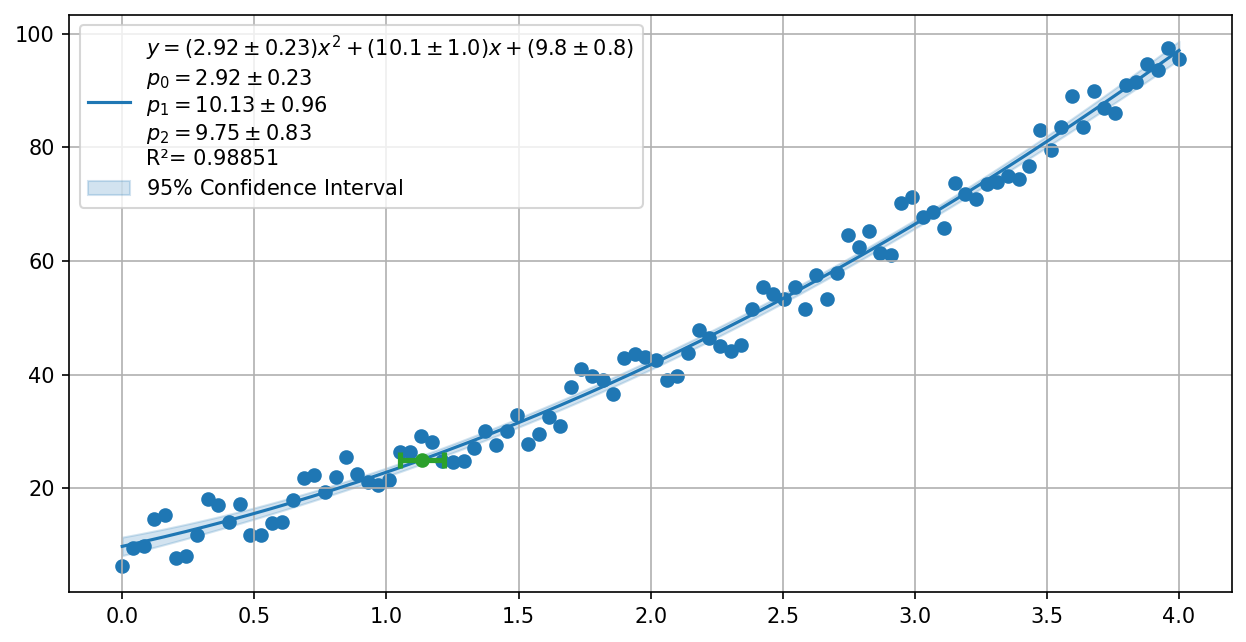

In [6]:
import uncertainties as unc
import matplotlib.pyplot as plt
import unc_tools.patches
from unc_tools import Poly

noise = np.random.uniform(low=-5, high=5, size= 100)
def f(x):
    # Quadratic model with additive noise.
    return 3 * x **2 + 10 * x + 10 + noise
x = np.linspace(0,4,100) 
y = f(x) 

reg = UncRegression(x,y, func=Poly(2))
ax = reg.plot(show_band=True, show_coefficients=True)

y0 = 25
x0_1 = reg.find_x(y0)
x0_2 = reg.find_x(y0, x0 = 5)
print(f"y = {y0}: ",x0_1, x0_2)
ax.scatter([x0_1[1]],[y0])

y0 = unc.ufloat(25,0.01)
x0_1 = reg.find_x(y0)
x0_2 = reg.find_x(y0, x0 = 5)
print(f"y = {y0}: ",x0_1, x0_2)


Collect both roots across many y values into a DataFrame.


In [7]:
import pandas as pd

df = pd.DataFrame({})

df["y"] = y 
x_ = reg.find_x(y)
# Store both roots for each y value.
df["x1"] = x_[:,0]
df["x2"] = x_[:,1]

df


,y,x1,x2
0,6.267159,-3.1+/-0.5,-0.39+/-0.12
1,9.535578,-3.4+/-0.4,-0.02+/-0.08
2,9.870180,-3.5+/-0.4,0.01+/-0.08
3,14.514560,-3.9+/-0.4,0.42+/-0.07
4,15.209402,-3.9+/-0.4,0.47+/-0.07
...,...,...,...
95,91.409166,-7.3+/-0.4,3.83+/-0.16
96,94.707686,-7.4+/-0.4,3.93+/-0.16
97,93.534793,-7.4+/-0.4,3.89+/-0.16
98,97.438062,-7.5+/-0.4,4.01+/-0.16


Visualize both root branches from the quadratic model.


<ErrorbarContainer object of 3 artists>

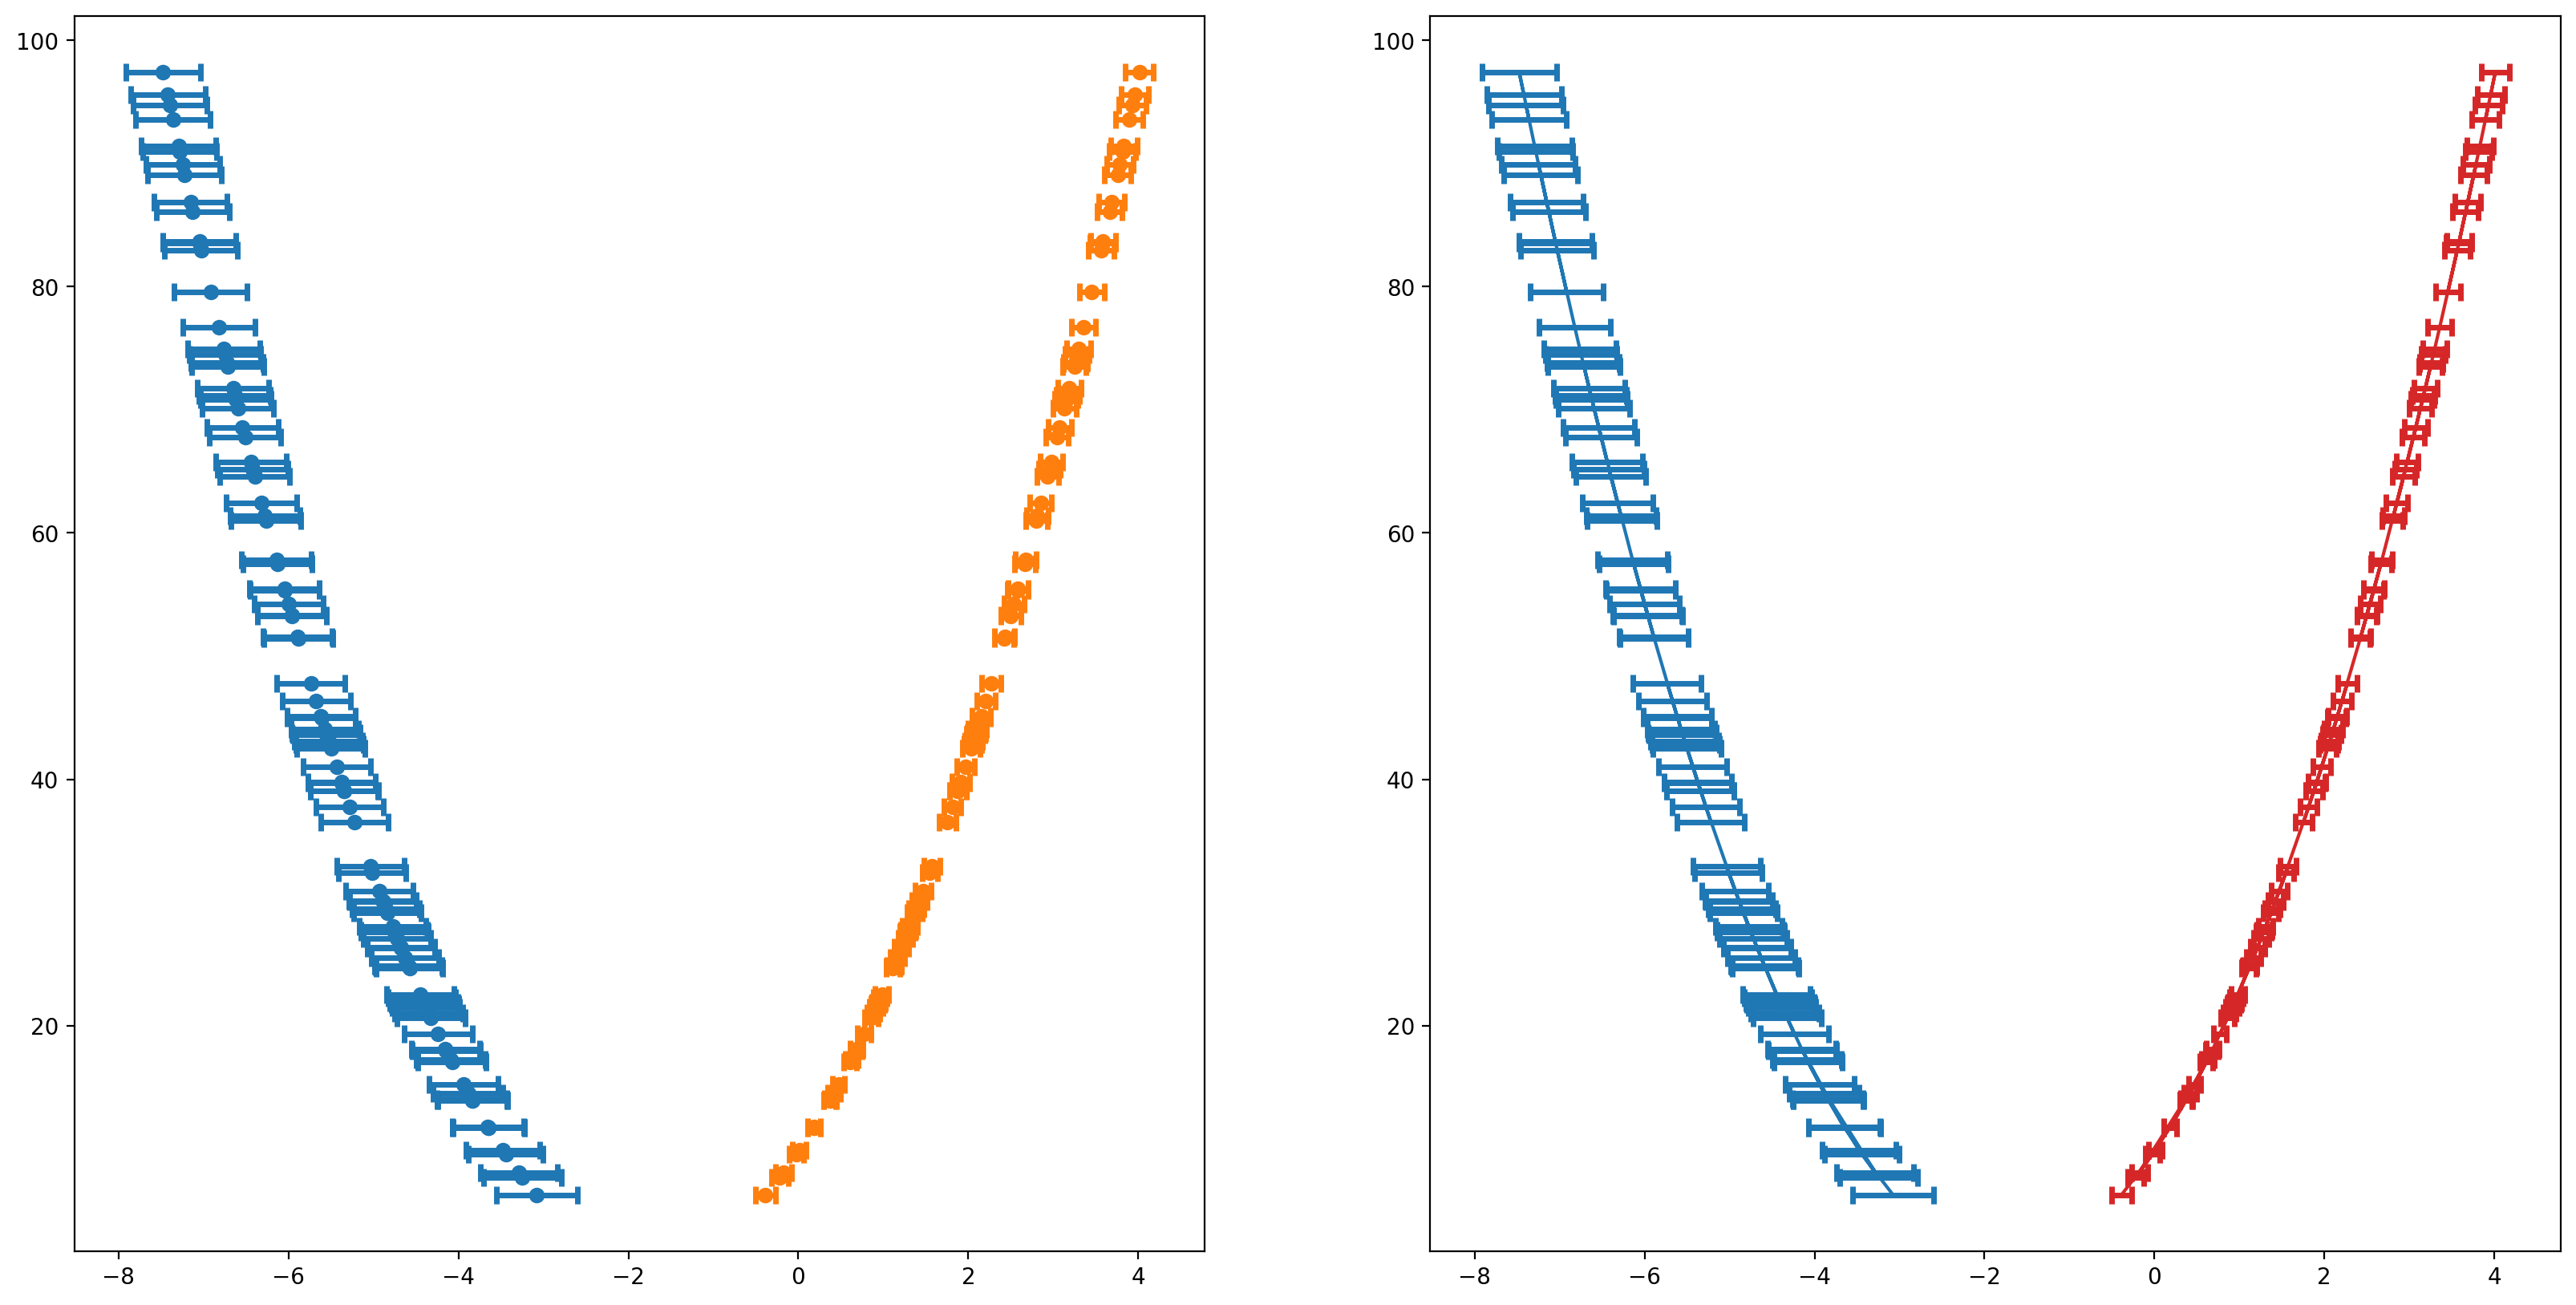

In [8]:
fig, axes = plt.subplots(1,2, figsize=(20,10), dpi=200)

axes[0].scatter(df.x1,df.y)
axes[0].scatter(df.x2,df.y)

axes[1].plot(df.x1,df.y)
axes[1].plot(df.x2,df.y)
